### 🔧 环境配置和检查

#### 概述

本教程需要特定的环境配置以确保最佳学习体验。以下配置将帮助您：

- 使用统一的conda环境：激活统一的学习环境
- 通过国内镜像源快速安装依赖：配置pip使用清华镜像源
- 加速模型下载：设置HuggingFace镜像代理
- 检查系统配置：检查硬件和软件配置

#### 配置

- **所需环境及其依赖已经部署好**
- 在`Notebook`右上角选择`jupyter内核`为`python(flyai_agent_in_action)`，即可执行下方代码

In [ ]:
%%script bash

# 1. 激活 conda 环境 (仅对当前单元格有效)
eval "$(conda shell.bash hook)"
conda activate flyai_agent_in_action

echo "========================================="
echo "== Conda 环境检查报告 (仅针对当前 Bash 子进程) =="
echo "========================================="

# 2. 检查当前激活的环境
CURRENT_ENV_NAME=$(basename $CONDA_PREFIX)

if [ "$CURRENT_ENV_NAME" = "flyai_agent_in_action" ]; then
    echo "✅ 当前单元格已成功激活到 flyai_agent_in_action 环境。"
    echo "✅ 正在使用的环境路径: $CONDA_PREFIX"
    echo ""
    echo "💡 提示: 后续的 Python 单元格将使用 Notebook 当前选择的 Jupyter 内核。"
    echo "   如果需要后续单元格也使用此环境，请执行以下操作:"
    echo "   1. 检查 Notebook 右上角是否已选择 'python(flyai_agent_in_action)'。"
else
    echo "❌ 激活失败或环境名称不匹配。当前环境: $CURRENT_ENV_NAME"
    echo ""
    echo "⚠️ 严重提示: 建议将 Notebook 的 Jupyter **内核 (Kernel)** 切换为 'python(flyai_agent_in_action)'。"
    echo "   (通常位于 Notebook 右上角或 '内核' 菜单中)"
    echo ""
    echo "📚 备用方法 (不推荐): 如果无法切换内核，则必须在**每个**代码单元格的头部重复以下命令:"
    echo ""
    echo "%%script bash"
    echo "# 必须在每个单元格都执行"
    echo "eval \"\$(conda shell.bash hook)\""
    echo "conda activate flyai_agent_in_action"
fi

echo "=========================================" 

In [ ]:
# 2. 设置pip 为清华源
%pip config set global.index-url https://pypi.tuna.tsinghua.edu.cn/simple
%pip config list

In [ ]:
# 3. 设置HuggingFace代理
%env HF_ENDPOINT=https://hf-mirror.com
# 验证：使用shell命令检查
!echo $HF_ENDPOINT

In [ ]:
# 🔍 环境信息检查脚本
#
# 本脚本的作用：
# 1. 安装 pandas 库用于数据表格展示
# 2. 检查系统的各项配置信息
# 3. 生成详细的环境报告表格
#
# 对于初学者来说，这个步骤帮助您：
# - 了解当前运行环境的硬件配置
# - 确认是否满足模型运行的最低要求
# - 学习如何通过代码获取系统信息

# 安装 pandas 库 - 用于创建和展示数据表格
# pandas 是 Python 中最流行的数据处理和分析库
%pip install pandas==2.2.2 tabulate==0.9.0

import platform # 导入 platform 模块以获取系统信息
import os # 导入 os 模块以与操作系统交互
import subprocess # 导入 subprocess 模块以运行外部命令
import pandas as pd # 导入 pandas 模块，通常用于数据处理，这里用于创建表格
import shutil # 导入 shutil 模块以获取磁盘空间信息

# 获取 CPU 信息的函数，包括核心数量
def get_cpu_info():
    cpu_info = "" # 初始化 CPU 信息字符串
    physical_cores = "N/A"
    logical_cores = "N/A"

    if platform.system() == "Windows": # 如果是 Windows 系统
        cpu_info = platform.processor() # 使用 platform.processor() 获取 CPU 信息
        try:
            # 获取 Windows 上的核心数量 (需要 WMI)
            import wmi
            c = wmi.WMI()
            for proc in c.Win32_Processor():
                physical_cores = proc.NumberOfCores
                logical_cores = proc.NumberOfLogicalProcessors
        except:
            pass # 如果 WMI 不可用，忽略错误

    elif platform.system() == "Darwin": # 如果是 macOS 系统
        # 在 macOS 上使用 sysctl 命令获取 CPU 信息和核心数量
        os.environ['PATH'] = os.environ['PATH'] + os.pathsep + '/usr/sbin' # 更新 PATH 环境变量
        try:
            process_brand = subprocess.Popen(['sysctl', "machdep.cpu.brand_string"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout_brand, stderr_brand = process_brand.communicate()
            cpu_info = stdout_brand.decode().split(': ')[1].strip() if stdout_brand else "Could not retrieve CPU info"

            process_physical = subprocess.Popen(['sysctl', "hw.physicalcpu"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout_physical, stderr_physical = process_physical.communicate()
            physical_cores = stdout_physical.decode().split(': ')[1].strip() if stdout_physical else "N/A"

            process_logical = subprocess.Popen(['sysctl', "hw.logicalcpu"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout_logical, stderr_logical = process_logical.communicate()
            logical_cores = stdout_logical.decode().split(': ')[1].strip() if stdout_logical else "N/A"

        except:
            cpu_info = "Could not retrieve CPU info"
            physical_cores = "N/A"
            logical_cores = "N/A"

    else:  # Linux 系统
        try:
            # 在 Linux 上读取 /proc/cpuinfo 文件获取 CPU 信息和核心数量
            with open('/proc/cpuinfo') as f:
                physical_cores_count = 0
                logical_cores_count = 0
                cpu_info_lines = []
                for line in f:
                    if line.startswith('model name'): # 查找以 'model name'开头的行
                        if not cpu_info: # 只获取第一个 model name
                            cpu_info = line.split(': ')[1].strip()
                    elif line.startswith('cpu cores'): # 查找以 'cpu cores' 开头的行
                        physical_cores_count = int(line.split(': ')[1].strip())
                    elif line.startswith('processor'): # 查找以 'processor' 开头的行
                        logical_cores_count += 1
                physical_cores = str(physical_cores_count) if physical_cores_count > 0 else "N/A"
                logical_cores = str(logical_cores_count) if logical_cores_count > 0 else "N/A"
                if not cpu_info:
                     cpu_info = "Could not retrieve CPU info"

        except:
            cpu_info = "Could not retrieve CPU info"
            physical_cores = "N/A"
            logical_cores = "N/A"

    return f"{cpu_info} ({physical_cores} physical cores, {logical_cores} logical cores)" # 返回 CPU 信息和核心数量


# 获取内存信息的函数
def get_memory_info():
    mem_info = "" # 初始化内存信息字符串
    if platform.system() == "Windows":
        # 在 Windows 上不容易通过标准库获取，需要外部库或 PowerShell
        mem_info = "Requires external tools on Windows" # 设置提示信息
    elif platform.system() == "Darwin": # 如果是 macOS 系统
        # 在 macOS 上使用 sysctl 命令获取内存大小
        process = subprocess.Popen(['sysctl', "hw.memsize"], stdout=subprocess.PIPE, stderr=subprocess.PIPE) # 运行 sysctl 命令
        stdout, stderr = process.communicate() # 获取标准输出和标准错误
        mem_bytes = int(stdout.decode().split(': ')[1].strip()) # 解析输出，获取内存大小（字节）
        mem_gb = mem_bytes / (1024**3) # 转换为 GB
        mem_info = f"{mem_gb:.2f} GB" # 格式化输出
    else:  # Linux 系统
        try:
            # 在 Linux 上读取 /proc/meminfo 文件获取内存信息
            with open('/proc/meminfo') as f:
                total_mem_kb = 0
                available_mem_kb = 0
                for line in f:
                    if line.startswith('MemTotal'): # 查找以 'MemTotal' 开头的行
                        total_mem_kb = int(line.split(':')[1].strip().split()[0]) # 解析行，获取总内存（KB）
                    elif line.startswith('MemAvailable'): # 查找以 'MemAvailable' 开头的行
                         available_mem_kb = int(line.split(':')[1].strip().split()[0]) # 解析行，获取可用内存（KB）

                if total_mem_kb > 0:
                    total_mem_gb = total_mem_kb / (1024**2) # 转换为 GB
                    mem_info = f"{total_mem_gb:.2f} GB" # 格式化输出总内存
                    if available_mem_kb > 0:
                        available_mem_gb = available_mem_kb / (1024**2)
                        mem_info += f" (Available: {available_mem_gb:.2f} GB)" # 添加可用内存信息
                else:
                     mem_info = "Could not retrieve memory info" # 如果读取文件出错，设置错误信息

        except:
            mem_info = "Could not retrieve memory info" # 如果读取文件出错，设置错误信息
    return mem_info # 返回内存信息

# 获取 GPU 信息的函数，包括显存
def get_gpu_info():
    try:
        # 尝试使用 nvidia-smi 获取 NVIDIA GPU 信息和显存
        result = subprocess.run(['nvidia-smi', '--query-gpu=name,memory.total', '--format=csv,noheader'], capture_output=True, text=True)
        if result.returncode == 0: # 如果命令成功执行
            gpu_lines = result.stdout.strip().split('\n') # 解析输出，获取 GPU 名称和显存
            gpu_info_list = []
            for line in gpu_lines:
                name, memory = line.split(', ')
                gpu_info_list.append(f"{name} ({memory})") # 格式化 GPU 信息
            return ", ".join(gpu_info_list) if gpu_info_list else "NVIDIA GPU found, but info not listed" # 返回 GPU 信息或提示信息
        else:
             # 尝试使用 lshw 获取其他 GPU 信息 (需要安装 lshw)
            try:
                result_lshw = subprocess.run(['lshw', '-C', 'display'], capture_output=True, text=True)
                if result_lshw.returncode == 0: # 如果命令成功执行
                     # 简单解析输出中的 product 名称和显存
                    gpu_info_lines = []
                    current_gpu = {}
                    for line in result_lshw.stdout.splitlines():
                        if 'product:' in line:
                             if current_gpu:
                                 gpu_info_lines.append(f"{current_gpu.get('product', 'GPU')} ({current_gpu.get('memory', 'N/A')})")
                             current_gpu = {'product': line.split('product:')[1].strip()}
                        elif 'size:' in line and 'memory' in line:
                             current_gpu['memory'] = line.split('size:')[1].strip()

                    if current_gpu: # 添加最后一个 GPU 的信息
                        gpu_info_lines.append(f"{current_gpu.get('product', 'GPU')} ({current_gpu.get('memory', 'N/A')})")

                    return ", ".join(gpu_info_lines) if gpu_info_lines else "GPU found (via lshw), but info not parsed" # 如果找到 GPU 但信息无法解析，设置提示信息
                else:
                    return "No GPU found (checked nvidia-smi and lshw)" # 如果两个命令都找不到 GPU，设置提示信息
            except FileNotFoundError:
                 return "No GPU found (checked nvidia-smi, lshw not found)" # 如果找不到 lshw 命令，设置提示信息
    except FileNotFoundError:
        return "No GPU found (nvidia-smi not found)" # 如果找不到 nvidia-smi 命令，设置提示信息


# 获取 CUDA 版本的函数
def get_cuda_version():
    try:
        # 尝试使用 nvcc --version 获取 CUDA 版本
        result = subprocess.run(['nvcc', '--version'], capture_output=True, text=True)
        if result.returncode == 0: # 如果命令成功执行
            for line in result.stdout.splitlines():
                if 'release' in line: # 查找包含 'release' 的行
                    return line.split('release ')[1].split(',')[0] # 解析行，提取版本号
        return "CUDA not found or version not parsed" # 如果找不到 CUDA 或版本无法解析，设置提示信息
    except FileNotFoundError:
        return "CUDA not found" # 如果找不到 nvcc 命令，设置提示信息

# 获取 Python 版本的函数
def get_python_version():
    return platform.python_version() # 获取 Python 版本

# 获取 Conda 版本的函数
def get_conda_version():
    try:
        # 尝试使用 conda --version 获取 Conda 版本
        result = subprocess.run(['conda', '--version'], capture_output=True, text=True)
        if result.returncode == 0: # 如果命令成功执行
            return result.stdout.strip() # 返回 Conda 版本
        return "Conda not found or version not parsed" # 如果找不到 Conda 或版本无法解析，设置提示信息
    except FileNotFoundError:
        return "Conda not found" # 如果找不到 conda 命令，设置提示信息

# 获取物理磁盘空间信息的函数
def get_disk_space():
    try:
        total, used, free = shutil.disk_usage("/") # 获取根目录的磁盘使用情况
        total_gb = total / (1024**3) # 转换为 GB
        used_gb = used / (1024**3) # 转换为 GB
        free_gb = free / (1024**3) # 转换为 GB
        return f"Total: {total_gb:.2f} GB, Used: {used_gb:.2f} GB, Free: {free_gb:.2f} GB" # 格式化输出
    except Exception as e:
        return f"Could not retrieve disk info: {e}" # 如果获取信息出错，设置错误信息

# 获取环境信息
os_name = platform.system() # 获取操作系统名称
os_version = platform.release() # 获取操作系统版本
if os_name == "Linux":
    try:
        # 在 Linux 上尝试获取发行版和版本
        lsb_info = subprocess.run(['lsb_release', '-a'], capture_output=True, text=True)
        if lsb_info.returncode == 0: # 如果命令成功执行
            for line in lsb_info.stdout.splitlines():
                if 'Description:' in line: # 查找包含 'Description:' 的行
                    os_version = line.split('Description:')[1].strip() # 提取描述信息作为版本
                    break # 找到后退出循环
                elif 'Release:' in line: # 查找包含 'Release:' 的行
                     os_version = line.split('Release:')[1].strip() # 提取版本号
                     # 尝试获取 codename
                     try:
                         codename_info = subprocess.run(['lsb_release', '-c'], capture_output=True, text=True)
                         if codename_info.returncode == 0:
                             os_version += f" ({codename_info.stdout.split(':')[1].strip()})" # 将 codename 添加到版本信息中
                     except:
                         pass # 如果获取 codename 失败则忽略

    except FileNotFoundError:
        pass # lsb_release 可能未安装，忽略错误

full_os_info = f"{os_name} {os_version}" # 组合完整的操作系统信息
cpu_info = get_cpu_info() # 调用函数获取 CPU 信息和核心数量
memory_info = get_memory_info() # 调用函数获取内存信息
gpu_info = get_gpu_info() # 调用函数获取 GPU 信息和显存
cuda_version = get_cuda_version() # 调用函数获取 CUDA 版本
python_version = get_python_version() # 调用函数获取 Python 版本
conda_version = get_conda_version() # 调用函数获取 Conda 版本
disk_info = get_disk_space() # 调用函数获取物理磁盘空间信息


# 创建用于存储数据的字典
env_data = {
    "项目": [ # 项目名称列表
        "操作系统",
        "CPU 信息",
        "内存信息",
        "GPU 信息",
        "CUDA 信息",
        "Python 版本",
        "Conda 版本",
        "物理磁盘空间" # 添加物理磁盘空间
    ],
    "信息": [ # 对应的信息列表
        full_os_info,
        cpu_info,
        memory_info,
        gpu_info,
        cuda_version,
        python_version,
        conda_version,
        disk_info # 添加物理磁盘空间信息
    ]
}

# 创建一个 pandas DataFrame
df = pd.DataFrame(env_data)

# 打印表格
print("### 环境信息") # 打印标题
print(df.to_markdown(index=False)) # 将 DataFrame 转换为 Markdown 格式并打印，不包含索引


<a href="https://colab.research.google.com/github/FlyAIBox/langchain-academy/blob/fly101/module-1/chain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chain（链）

## Review（回顾）

我们此前构建了一个简单的有向图：包含节点、普通边，以及“条件边（根据判断分支）”。

## Goals（目标）

现在我们把 4 个核心概念串成一条“链”（Chain）（参考文档链接）：

- 使用[聊天消息](https://python.langchain.com/docs/concepts/#messages)作为图的状态（state）
- 在图的节点中使用[聊天模型](https://python.langchain.com/docs/concepts/#chat-models)
- 将[工具](https://python.langchain.com/docs/concepts/#tools)绑定到聊天模型
- 在图的节点中[执行工具调用](https://python.langchain.com/docs/concepts/#functiontool-calling)

![链式结构示意图](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dd607b08df5e1101_chain1.png)

In [1]:
%%capture --no-stderr
# %pip install --quiet -U langchain_openai langchain_core langgraph
%pip install --quiet langchain_openai==0.3.32 langchain_core==0.3.75 langgraph==0.6.7

## Messages（消息）

聊天模型使用[`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages)来承载对话上下文，其中每条消息都有“角色（role）”。

LangChain 支持多种消息类型：`HumanMessage`（用户）、`AIMessage`（模型/助手）、`SystemMessage`（系统指令）、`ToolMessage`（工具调用返回）。

它们分别表示：用户发言、模型回复、面向模型的系统指令、以及某个工具调用产生的消息。

下面我们来创建一个消息列表。

每条消息通常包含：

- `content`：消息内容（必填）
- `name`：消息作者（可选）
- `response_metadata`：响应元数据（可选，通常由模型提供方自动填充于 `AIMessage`）

In [6]:
# 初学者提示：本示例演示如何构造“对话消息列表（messages）”，供聊天模型作为上下文输入。
# - HumanMessage 表示“人类（用户）”消息
# - AIMessage 表示“模型（助手）”消息
# - 每条消息可包含：content（内容）、name（可选的说话者名）、response_metadata（模型返回时的元数据）
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

# 我们用一个列表来按时间顺序保存对话历史。
messages = [AIMessage(content=f"你说你在研究海洋哺乳动物？", name="Model")]
# 追加一条来自用户的消息
messages.append(HumanMessage(content=f"是的，没错。",name="Lance"))
# 再追加一条来自模型的消息
messages.append(AIMessage(content=f"好的，你想了解什么？", name="Model"))
# 用户继续追问
messages.append(HumanMessage(content=f"我想了解在美国哪里最适合看虎鲸。", name="Lance"))

# 以更易读的格式打印每条消息，便于检查结构与顺序
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

你说你在研究海洋哺乳动物？
================================ Human Message =================================
Name: Lance

是的，没错。
================================== Ai Message ==================================
Name: Model

好的，你想了解什么？
================================ Human Message =================================
Name: Lance

我想了解在美国哪里最适合看虎鲸。


## Chat Models（聊天模型）

[聊天模型](https://python.langchain.com/v0.2/docs/concepts/#chat-models)以“消息序列”作为输入，并支持上文提到的多种消息类型。

可选模型提供商有很多（见上方链接）。这里以 OpenAI 为例。

我们先检查环境变量 `OPENAI_API_KEY` 是否已设置；如果没有，将在 Notebook 中提示你安全输入。

In [12]:
# 初学者提示：许多大模型 SDK 通过环境变量读取密钥（如 OPENAI_API_KEY）。
# 下面的辅助函数用于在未设置时，交互式地提示输入并写入当前进程环境变量。
# 注意：Notebook 会话结束后，需重新设置或在系统环境中长期配置。
import os, getpass

def _set_env(var: str):
    # 若系统环境中没有该变量，则通过安全输入进行设置
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

# 设置 OpenAI 的 API Key，供 ChatOpenAI 使用
_set_env("OPENAI_API_KEY")
# 设置 OpenAI API代理地址 (例如：https://api.apiyi.com/v1）
_set_env("OPENAI_BASE_URL")

OPENAI_API_KEY: ··········
OPENAI_BASE_URL: ··········


我们可以加载一个聊天模型，并用我们的消息列表调用它。

你会看到返回的是一条 `AIMessage`，其中包含特定的 `response_metadata`（响应元数据）。

In [13]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")
result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [14]:
result

AIMessage(content='如果你想在美国观赏虎鲸，华盛顿州的圣胡安群岛是一个非常理想的地点。这片区域是北太平洋虎鲸（也称为逆戟鲸）在春季和夏季常驻的地方，尤其是捕鱼的时节。岛屿附近的海域生态多样，有丰富的食物来源，吸引了许多虎鲸来此捕食和生活。\n\n此外，阿拉斯加的内湾水域、加利福尼亚海岸，以及俄勒冈州和华盛顿州沿海也可能提供一些观赏虎鲸的机会，特别是在季节性迁徙期间。不过，圣胡安群岛被认为是观赏虎鲸的首选地点之一，因为这里有定期的船只观鲸旅游，可以近距离观察这些壮观的动物。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 187, 'prompt_tokens': 64, 'total_tokens': 251, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}, 'input_tokens': 0, 'output_tokens': 0, 'input_tokens_details': None}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_5d58a6052a', 'id': 'chatcmpl-CE8vgZ6OyVVPmlSruDc2sfIIX82K8', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--a993107d-1070-4844-928c-16eef5d02d3d-0', usage_metadata={'input_tokens': 64, 'output_tokens': 187, 'total_tokens': 251, 'input_token_details': {'audi

In [15]:
result.response_metadata

{'token_usage': {'completion_tokens': 187,
  'prompt_tokens': 64,
  'total_tokens': 251,
  'completion_tokens_details': {'accepted_prediction_tokens': 0,
   'audio_tokens': 0,
   'reasoning_tokens': 0,
   'rejected_prediction_tokens': 0},
  'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0},
  'input_tokens': 0,
  'output_tokens': 0,
  'input_tokens_details': None},
 'model_name': 'gpt-4o',
 'system_fingerprint': 'fp_5d58a6052a',
 'id': 'chatcmpl-CE8vgZ6OyVVPmlSruDc2sfIIX82K8',
 'service_tier': None,
 'finish_reason': 'stop',
 'logprobs': None}

## Tools
当您希望模型与外部系统交互时，工具很有用。
外部系统（例如 API）通常需要特定的输入模式或有效负载，而不是自然语言。
例如，当我们绑定 API 作为一种工具时，我们赋予模型对所需输入模式的感知。
该模型将根据用户的自然语言输入选择调用工具。
并且，它将返回符合该工具模式的输出。
[许多LLM提供商都支持工具调用](https://python.langchain.com/docs/integrations/chat/) ，并且 [LangChain中的工具调用接口](https://blog.langchain.com/improving-core-tool-interfaces-and-docs-in-langchain/)非常简单。
您可以简单地将任何 Python function 传递到 ChatModel.bind_tools(function) 。


我们用一个极简示例演示工具调用。

这里把 `multiply` 函数当作我们的“工具”。

In [17]:
# 初学者提示：把一个 Python 函数以“工具（tool）”的形式绑定给聊天模型。
# 作用：当任务需要结构化操作（如计算、查库、调 API），模型会优先生成工具调用参数并返回 tool_calls。
# 关键点：
# - 函数签名即是工具的“输入模式”，参数类型应明确；
# - 返回值需可序列化、简洁明确；
# - bind_tools([...]) 将工具元信息注册给模型。

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# 将 multiply 工具绑定到聊天模型实例
llm_with_tools = llm.bind_tools([multiply])

如果我们传递一个输入 - 例如 "What is 2 multiplied by 3" - 我们会看到返回一个工具调用。

工具调用具有与我们函数的输入模式以及要调用的函数的名称相匹配的特定参数。

```
{'arguments': '{"a":2,"b":3}', 'name': 'multiply'}
```

In [18]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 2 multiplied by 3", name="Lance")])

In [ ]:
tool_call.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'call_lBBBNo5oYpHGRqwxNaNRbsiT',
  'type': 'tool_call'}]

## Using messages as state

有了这些基础，我们现在可以在图形状态中使用[`messages`](https://python.langchain.com/docs/concepts/#messages).


我们将状态 `MessagesState` 定义为具有单个键 `messages` 的 `TypedDict` 。

`messages` 只是一个消息列表，正如我们上面所定义的（例如 `HumanMessage` 等）。 我们将状态 `MessagesState` 定义为具有单个键消息的 `TypedDict` 。

In [19]:
# 定义图状态（State）：使用 TypedDict 定义键 messages
# 含义：messages 用于保存对话历史（列表），元素类型是 AnyMessage（可包含 Human/AI/Tool 等消息）
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
    messages: list[AnyMessage]

## Reducers（归并器）

这里会遇到一个小问题：

按默认行为，每个节点返回的 `messages` 新值会[覆盖](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers)旧值。

但在对话场景中，我们希望在运行过程中不断“追加”消息到 `messages`，而不是覆盖。

为此可以使用[归并器（reducer）](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers)来定义“状态更新的合并规则”。

- 如果没有为某个键指定 reducer，则该键的更新将采用“覆盖”语义。
- 若要把消息追加到列表，应使用内置的 `add_messages` 归并器。

做法是：在状态类型中为 `messages` 键添加 `add_messages` 作为元数据注解，从而实现“追加而非覆盖”。

In [20]:
# Reducer（归并器）：指定当节点返回新的 messages 时，如何与已有状态合并。
# add_messages 的语义是“追加消息而非覆盖”，保证完整的对话上下文得以保留。
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

将消息列表保存在图状态中非常常见，LangGraph 已内置 [`MessagesState`](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate)。

该类型具备以下特性：

- 预置一个 `messages` 键
- 值类型为 `list[AnyMessage]`
- 已默认使用 `add_messages` 归并器（自动追加）

因此通常直接使用内置的 `MessagesState`，比自定义 `TypedDict` 更简洁。

In [21]:
# LangGraph 内置 MessagesState：已包含 messages 键与 add_messages 逻辑。
# 如需扩展，可继承后新增自定义键（如检索开关、工具开关、用户画像等）。
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built
    pass

进一步了解：下面用一个最小示例单独演示 `add_messages` 归并器如何把新消息追加到已有列表中。

In [23]:
# Initial state
initial_messages = [AIMessage(content="您好！有什么可以为您效劳的？", name="Model"),
           HumanMessage(content="我正在寻找有关海洋生物学的信息。", name="Lance")
                   ]

# New message to add
new_message = AIMessage(content="好的，我很乐意帮忙。您具体对什么感兴趣？", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='您好！有什么可以为您效劳的？', additional_kwargs={}, response_metadata={}, name='Model', id='dee4d536-1ab0-4d40-a79c-9a7f76e8a791'),
 HumanMessage(content='我正在寻找有关海洋生物学的信息。', additional_kwargs={}, response_metadata={}, name='Lance', id='1562f9f6-0d99-4125-bfe7-d26e3eff2047'),
 AIMessage(content='好的，我很乐意帮忙。您具体对什么感兴趣？', additional_kwargs={}, response_metadata={}, name='Model', id='9d758673-f136-409c-873e-fabc4693241d')]

## Our graph（我们的图）

下面用内置的 `MessagesState` 搭建一条最简单的“链式”对话图。

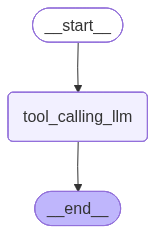

In [24]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# 节点函数：接收并返回“状态增量（partial state）”
# 入参 state：包含键 messages 的字典（对话历史）
# 返回：{"messages": [...]} —— 追加一条模型回复（可能包含工具调用）
# 注意：由于上文使用了 add_messages 作为 reducer，这里返回的列表会被“追加”到现有状态。
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"]) ]}

# 构建图
builder = StateGraph(MessagesState)
# 注册节点：名称 "tool_calling_llm" 对应上面的节点函数
builder.add_node("tool_calling_llm", tool_calling_llm)
# 拓扑：从 START 进入该节点，再从该节点到 END，形成一条“链”
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
# 编译图为可执行对象
graph = builder.compile()

# 可视化：通过 Mermaid 渲染图结构
display(Image(graph.get_graph().draw_mermaid_png()))

当输入 `Hello!` 这样的问候语时，模型会直接自然语言回复，不会触发任何工具调用。

In [25]:
# 运行图（不涉及工具调用的普通对话）：
# 期望：模型直接以自然语言回复，不返回 tool_calls。
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hi there! How can I assist you today?


当模型判断用户输入/任务需要某个工具所提供的能力时，它会选择触发相应的工具调用。

In [26]:
# 运行图（触发工具调用的请求）：
# 期望：模型返回带有 tool_calls 的 AIMessage，工具名与参数应符合 multiply(a, b)。
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_ymaemHaIDegCIPK7qutwPkh0)
 Call ID: call_ymaemHaIDegCIPK7qutwPkh0
  Args:
    a: 2
    b: 3
